Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

#### 1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [62]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression


%matplotlib inline

import warnings
warnings.simplefilter("ignore")


import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
df_train = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/train.csv')
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_application = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv')
df_bki = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/bki.csv')
df_client_profile = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv')
df_payments = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/payments.csv')


In [3]:
df_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [5]:
df_test.head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


трейн и тест без пропусков. любопытный момент, что в тесте данных больше, чем в трейне. 

In [7]:
df_client_profile.head()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,...,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [8]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

данных по предыдущим кредитам также может быть несколько на каждый номер заявки. 

In [9]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')


In [10]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


In [11]:
df_test_merged = pd.merge(df_test, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [12]:
df_test_merged

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0
1,123456549,Cash,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,...,4.0,NaN,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0
2,123428178,Credit Card,F,2.0,157500.0,450000.0,22500.0,Secondary / secondary special,Married,0.019101,...,4.0,NaN,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0
3,123619984,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123671104,Cash,F,1.0,90000.0,254700.0,24939.0,Higher education,Married,0.015221,...,3.0,0.718604,0.505704,0.415347,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165137,123536402,Cash,M,0.0,135000.0,450000.0,16807.5,Secondary / secondary special,Single / not married,0.028663,...,1.0,NaN,0.665971,0.535276,0.0,0.0,0.0,0.0,0.0,0.0
165138,123718238,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165139,123631557,Cash,F,0.0,112500.0,350181.0,36769.5,Secondary / secondary special,Married,0.030755,...,2.0,NaN,0.761376,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_train_merged.columns


Index(['APPLICATION_NUMBER', 'TARGET', 'NAME_CONTRACT_TYPE', 'GENDER',
       'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [14]:
class MissingImputer():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        df['FAMILY_STATUS'].fillna('Unknown', inplace=True)
        
        numerical_features = df.select_dtypes(include=[np.number])
        
        cat_features = df.select_dtypes(include = ['object'])

        for num in numerical_features:
            numerical_features.loc[(numerical_features[num].isnull(), [num])] = numerical_features[num].median()

        for cat in cat_features:
            cat_features.loc[(cat_features[cat].isnull(), [cat])] = df[cat].mode()[0]
                        
        for cat in cat_features:
            #enc = LabelEncoder()
            #cat_features[cat] = enc.fit_transform(cat_features[cat])
            cat_features = pd.concat([cat_features, pd.get_dummies(cat_features[cat], prefix=cat)], axis=1)
            
        #cat_features = cat_features.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
        df = pd.concat([numerical_features, cat_features], axis=1)
        
        df["DAYS_ON_LAST_JOB"] = df["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
        bki_flags = [flag for flag in df.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
        df["bki_requests_count"] = df[bki_flags].sum(axis=1)
        df["bki_kurtosis"] = df[bki_flags].kurtosis(axis=1)

        df["external_scoring_prod"] = df["EXTERNAL_SCORING_RATING_1"] * df["EXTERNAL_SCORING_RATING_2"] * df["EXTERNAL_SCORING_RATING_3"]
        df["external_scoring_weighted"] = df.EXTERNAL_SCORING_RATING_1 * 2 + df.EXTERNAL_SCORING_RATING_2 * 1 + df.EXTERNAL_SCORING_RATING_3 * 3

        for function_name in ["min", "max", "mean", "nanmedian", "var"]:
            feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
            df[feature_name] = eval("np.{}".format(function_name))(
                df[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
            )

        # Отношение между основными фин. показателями
        df['ratio_credit_to_annuity'] = df['AMOUNT_CREDIT'] / df['AMOUNT_ANNUITY']
        df["ratio_annuity_to_salary"] = df['AMOUNT_ANNUITY'] / df['TOTAL_SALARY']
        df['ratio_credit_to_salary'] = df['AMOUNT_CREDIT'] / df['TOTAL_SALARY']
        #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

        # Отношение фин. показателей к возрасту и временным фичам
        df["ratio_annuity_to_age"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["ratio_credit_to_age"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["ratio_salary_to_age"] = df["TOTAL_SALARY"] / df["AGE"]
        df["ratio_salary_to_experience"] = df["TOTAL_SALARY"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_credit_to_experience"] = df["AMOUNT_CREDIT"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_annuity_to_experience"] = df["AMOUNT_ANNUITY"] / df["DAYS_ON_LAST_JOB"]

        # Отношение врменных признаков
        df["ratio_age_to_experience"] = df["AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_salary_to_region_population"] = df["TOTAL_SALARY"] * df["REGION_POPULATION"]
        df["ratio_car_to_experience"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_car_to_age"] = df["OWN_CAR_AGE"] / df["AGE"]

        # Произведение фин. показателей кредита на вероятность дефолта
        # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
        df["expected_total_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_CREDIT"]
        df["expected_total_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_CREDIT"]
        df["expected_total_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_CREDIT"]
        df["expected_monthly_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_ANNUITY"]
        df["expected_monthly_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_ANNUITY"]
        df["expected_monthly_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_ANNUITY"]

        #Генерация новых признаков
        df['Credit_card_man_XNA'] = 0
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
        df['Credit_card_education'] = 0
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
        df['Credit_card_marital'] = 1
        df.loc[(df['NAME_CONTRACT_TYPE'] == 'Cash') | (df['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

        
        return df

In [15]:
imputer = MissingImputer()

imputer.fit(df_train_merged)

df_train_merged = imputer.transform(df_train_merged)
df_test_merged = imputer.transform(df_test_merged)

In [16]:
df_train_merged = df_train_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
df_test_merged = df_test_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)

В целом, за исключением ряда небольших отклонений, распределения в тестовой и обучающей выборке совпадают. 

In [17]:
target = df_train_merged["TARGET"]
target

0         0
1         1
2         0
3         1
4         1
         ..
110088    0
110089    0
110090    0
110091    0
110092    0
Name: TARGET, Length: 110093, dtype: int64

In [18]:
correlation = df_train_merged.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

TARGET                                           1.000000
EXTERNAL_SCORING_RATING_var                      0.061397
EDUCATION_LEVEL_Secondary / secondary special    0.045948
GENDER_M                                         0.043532
ratio_car_to_age                                 0.039006
                                                   ...   
EXTERNAL_SCORING_RATING_min                     -0.162035
external_scoring_prod                           -0.170404
EXTERNAL_SCORING_RATING_nanmedian               -0.173989
external_scoring_weighted                       -0.187810
EXTERNAL_SCORING_RATING_mean                    -0.199136
Name: TARGET, Length: 69, dtype: float64

In [19]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [20]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, df_train_merged = df_train_merged["TARGET"], df_train_merged.drop(["TARGET"], axis=1)

In [21]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_merged, target, cv
)

Mon Dec 14 01:46:27 2020, Cross-Validation, 110093 rows, 68 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.724256	valid_0's binary_logloss: 0.270426
[100]	valid_0's auc: 0.72604	valid_0's binary_logloss: 0.264422
[150]	valid_0's auc: 0.727762	valid_0's binary_logloss: 0.26068
[200]	valid_0's auc: 0.728714	valid_0's binary_logloss: 0.258074
[250]	valid_0's auc: 0.730029	valid_0's binary_logloss: 0.256273
[300]	valid_0's auc: 0.730897	valid_0's binary_logloss: 0.254959
[350]	valid_0's auc: 0.731967	valid_0's binary_logloss: 0.253996
[400]	valid_0's auc: 0.733071	valid_0's binary_logloss: 0.253218
[450]	valid_0's auc: 0.734665	valid_0's binary_logloss: 0.252518
[500]	valid_0's auc: 0.735573	valid_0's binary_logloss: 0.251916
[550]	valid_0's auc: 0.737365	valid_0's binary_logloss: 0.251429
[600]	valid_0's auc: 0.737907	valid_0's binary_logloss: 0.251058
[650]	valid_0's auc: 0.738509	valid_0's binary_logloss: 0.250688
[700]	valid_0's auc: 0.739353	

Fold 7, Valid score = 0.7188
Score by each fold: [0.74033, 0.73843, 0.72922, 0.71209, 0.72189, 0.71114, 0.7188]


In [22]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

Score = 0.7242


In [23]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [24]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, df_train_merged, target, xgb_cv
)

Mon Dec 14 01:47:30 2020, Cross-Validation, 110093 rows, 68 cols
[01:47:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69222	valid-auc:0.70460
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.70881	valid-auc:0.72499
[20]	train-auc:0.71052	valid-auc:0.72601
[30]	train-auc:0.71368	valid-auc:0.72934
[40]	train-auc:0.71642	valid-auc:0.72982
[50]	train-auc:0.72021	valid-auc:0.73160
[60]	train-auc:0.72313	valid-auc:0.73296
[70]	train-auc:0.72799	valid-auc:0.73703
[80]	train-auc:0.73168	valid-auc:0.73897
[90]	train-auc:0.73452	valid-auc:0.

[20]	train-auc:0.71335	valid-auc:0.70194
[30]	train-auc:0.71583	valid-auc:0.70224
[40]	train-auc:0.71917	valid-auc:0.70339
[50]	train-auc:0.72230	valid-auc:0.70580
[60]	train-auc:0.72606	valid-auc:0.70800
[70]	train-auc:0.73059	valid-auc:0.71178
[80]	train-auc:0.73371	valid-auc:0.71447
[90]	train-auc:0.73668	valid-auc:0.71688
[100]	train-auc:0.73929	valid-auc:0.71757
[110]	train-auc:0.74189	valid-auc:0.71896
[120]	train-auc:0.74343	valid-auc:0.71993
[130]	train-auc:0.74522	valid-auc:0.72059
[140]	train-auc:0.74692	valid-auc:0.72180
[150]	train-auc:0.74822	valid-auc:0.72163
[160]	train-auc:0.74949	valid-auc:0.72226
[170]	train-auc:0.75065	valid-auc:0.72299
[180]	train-auc:0.75182	valid-auc:0.72275
[190]	train-auc:0.75281	valid-auc:0.72340
[200]	train-auc:0.75390	valid-auc:0.72357
[210]	train-auc:0.75526	valid-auc:0.72305
Stopping. Best iteration:
[188]	train-auc:0.75271	valid-auc:0.72358

Fold 6, Valid score = 0.72293
[01:49:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_re

In [25]:
score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(score, 4)}")

Score = 0.7256


In [26]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds_lgbm,
    "xgb_numerical": xgb_oof,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

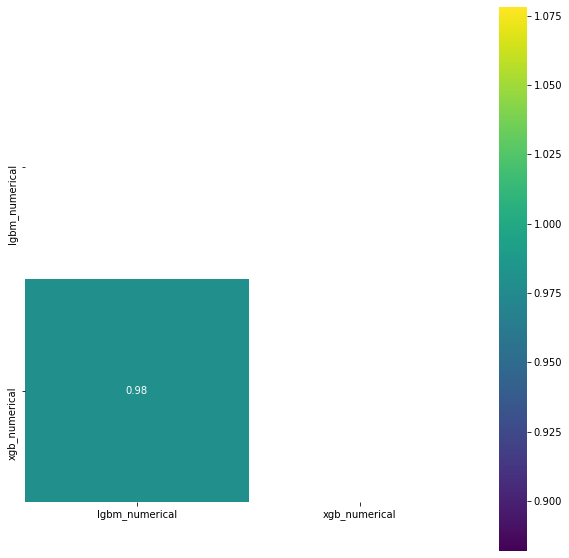

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [28]:
categorial = df_train_merged.dtypes[df_train_merged.dtypes == "object"].index
numerical = list(set(df_train_merged.columns) - set(categorial))

y_pred = np.zeros(df_test_merged.shape[0])
df_test_merged[numerical] = df_test_merged[numerical].astype(float)
df_test_merged[categorial] = df_test_merged[categorial].astype(str)

for estimator in estimators:
    y_pred += estimator.predict_proba(df_test_merged)[:, 1]

In [29]:
test_id = df_test["APPLICATION_NUMBER"]

y_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred / cv.n_splits
})
y_pred.to_csv("Kaldin_lgbm_xgb_1.csv", index=False)

In [30]:
y_pred_xgb = np.zeros(df_test_merged.shape[0])
dtest = xgb.DMatrix(data=df_test_merged)

for estimator in xgb_estimators:
    y_pred_xgb += estimator.predict(dtest)[:, 1]
    
y_pred_xgb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred / cv.n_splits
})
y_pred.to_csv("Kaldin_lgbm_xgb_2.csv", index=False)

IndexError: too many indices for array

Модели показали корелляцию 0.98 на трейне, но XGB не получилось реализовать на тесте..

#### 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [31]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.7252


In [32]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7253


In [33]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.725


In [34]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.725


Модель XGB чуть лучше, но усредняется по всем параметрам почти одинаково, по по геометрическому среднему чуть лучше. 

#### 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.


In [35]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [44]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 8,
    "random_seed": 42
}

cv = KFold(n_splits=3, random_state=42, shuffle=True)

estimators_cb, oof_preds_cb = catboost_cross_validation(
    params=cb_params, X=df_train_merged, y=target, cv=cv, categorical=categorial
)

Mon Dec 14 01:59:44 2020, Cross-Validation, 110093 rows, 68 cols
0:	test: 0.6813156	test1: 0.6818644	best: 0.6818644 (0)	total: 24.2ms	remaining: 48.4s
10:	test: 0.6995275	test1: 0.7083354	best: 0.7089561 (2)	total: 262ms	remaining: 47.3s
20:	test: 0.6995982	test1: 0.7077871	best: 0.7089561 (2)	total: 568ms	remaining: 53.5s
30:	test: 0.7014634	test1: 0.7092666	best: 0.7092666 (30)	total: 895ms	remaining: 56.9s
40:	test: 0.7024069	test1: 0.7096909	best: 0.7097930 (39)	total: 1.22s	remaining: 58.5s
50:	test: 0.7039160	test1: 0.7108873	best: 0.7108873 (50)	total: 1.47s	remaining: 56.2s
60:	test: 0.7040072	test1: 0.7111962	best: 0.7111962 (60)	total: 1.78s	remaining: 56.5s
70:	test: 0.7039446	test1: 0.7114610	best: 0.7114610 (70)	total: 2.1s	remaining: 57.1s
80:	test: 0.7046931	test1: 0.7115437	best: 0.7116477 (78)	total: 2.43s	remaining: 57.6s
90:	test: 0.7055147	test1: 0.7124537	best: 0.7125853 (87)	total: 2.78s	remaining: 58.4s
100:	test: 0.7064521	test1: 0.7131375	best: 0.7131375 (100)

910:	test: 0.7429988	test1: 0.7305766	best: 0.7305766 (910)	total: 27.4s	remaining: 32.8s
920:	test: 0.7432713	test1: 0.7307882	best: 0.7307882 (920)	total: 27.7s	remaining: 32.4s
930:	test: 0.7435368	test1: 0.7307629	best: 0.7308072 (923)	total: 28s	remaining: 32.2s
940:	test: 0.7437419	test1: 0.7306003	best: 0.7308072 (923)	total: 28.3s	remaining: 31.9s
950:	test: 0.7439848	test1: 0.7305379	best: 0.7308072 (923)	total: 28.7s	remaining: 31.6s
960:	test: 0.7443449	test1: 0.7307032	best: 0.7308072 (923)	total: 28.9s	remaining: 31.3s
970:	test: 0.7446772	test1: 0.7307346	best: 0.7308072 (923)	total: 29.3s	remaining: 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7308071891
bestIteration = 923

Shrink model to first 924 iterations.
Fold 1, Valid score = 0.73081
0:	test: 0.6445433	test1: 0.6401887	best: 0.6401887 (0)	total: 26.7ms	remaining: 53.3s
10:	test: 0.7025429	test1: 0.6968196	best: 0.6968196 (10)	total: 295ms	remaining: 53.4s
20:	test: 0.7076701	test1: 0.70

830:	test: 0.7441036	test1: 0.7216440	best: 0.7216517 (829)	total: 22.3s	remaining: 31.4s
840:	test: 0.7443250	test1: 0.7217574	best: 0.7217574 (840)	total: 22.6s	remaining: 31.1s
850:	test: 0.7445169	test1: 0.7218369	best: 0.7218832 (844)	total: 22.8s	remaining: 30.8s
860:	test: 0.7448974	test1: 0.7217374	best: 0.7218832 (844)	total: 23.2s	remaining: 30.6s
870:	test: 0.7451059	test1: 0.7217523	best: 0.7218832 (844)	total: 23.4s	remaining: 30.3s
880:	test: 0.7453609	test1: 0.7218108	best: 0.7218832 (844)	total: 23.6s	remaining: 30s
890:	test: 0.7455179	test1: 0.7219066	best: 0.7219225 (889)	total: 23.9s	remaining: 29.8s
900:	test: 0.7458213	test1: 0.7219949	best: 0.7220226 (897)	total: 24.2s	remaining: 29.5s
910:	test: 0.7460344	test1: 0.7219698	best: 0.7220226 (897)	total: 24.5s	remaining: 29.2s
920:	test: 0.7462988	test1: 0.7218581	best: 0.7220226 (897)	total: 24.7s	remaining: 29s
930:	test: 0.7465311	test1: 0.7219876	best: 0.7220226 (897)	total: 25s	remaining: 28.7s
940:	test: 0.746

510:	test: 0.7352849	test1: 0.7105620	best: 0.7106040 (508)	total: 16.4s	remaining: 47.7s
520:	test: 0.7357313	test1: 0.7107074	best: 0.7107074 (520)	total: 16.6s	remaining: 47.2s
530:	test: 0.7360710	test1: 0.7107835	best: 0.7107835 (530)	total: 16.9s	remaining: 46.8s
540:	test: 0.7365419	test1: 0.7109051	best: 0.7109497 (537)	total: 17.2s	remaining: 46.3s
550:	test: 0.7368624	test1: 0.7110482	best: 0.7110482 (550)	total: 17.5s	remaining: 45.9s
560:	test: 0.7371378	test1: 0.7111012	best: 0.7111012 (560)	total: 17.7s	remaining: 45.4s
570:	test: 0.7374788	test1: 0.7113518	best: 0.7113518 (570)	total: 18s	remaining: 45s
580:	test: 0.7379030	test1: 0.7114632	best: 0.7114632 (580)	total: 18.3s	remaining: 44.6s
590:	test: 0.7381919	test1: 0.7115114	best: 0.7115297 (586)	total: 18.6s	remaining: 44.2s
600:	test: 0.7385713	test1: 0.7117333	best: 0.7117333 (600)	total: 18.9s	remaining: 43.9s
610:	test: 0.7389890	test1: 0.7118075	best: 0.7118198 (609)	total: 19.2s	remaining: 43.5s
620:	test: 0.7

In [45]:
oof_score = roc_auc_score(
    target, oof_preds_cb
)
print(f"OOF-score = {round(oof_score, 4)}")

OOF-score = 0.7221


In [46]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds_lgbm,
    "xgb_numerical": xgb_oof,
    "сb_numerical": oof_preds_cb,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

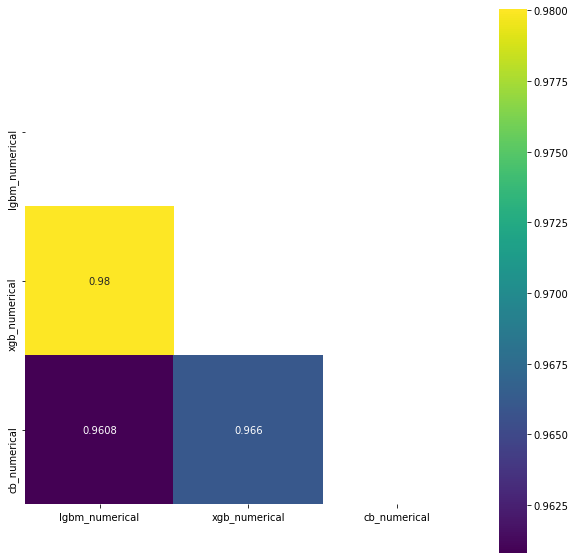

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [48]:
y_pred_cb = np.zeros(df_test_merged.shape[0])

for estimator in estimators_cb:
    y_pred_cb += estimator.predict_proba(df_test_merged)[:, 1]

In [49]:
test_id = df_test["APPLICATION_NUMBER"]

y_pred_cb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_cb / cv.n_splits
})
y_pred_cb.to_csv("Kaldin_lgbm_xgb_cb_1.csv", index=False)

#### 4. Выполнить задание 2 для трех моделей.


In [50]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.7251


In [51]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7252


In [52]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7248


In [53]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7248


Также геом. среднее дает лучший результат, но он чуть хуже первого

#### 5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.


In [54]:
OOF_preds = pd.DataFrame(oof_preds_lgbm)


In [56]:
OOF_preds = pd.concat([OOF_preds, pd.DataFrame(xgb_oof)], axis=1)

In [58]:
OOF_preds = pd.concat([OOF_preds, pd.DataFrame(oof_preds_cb)], axis=1)

In [60]:
OOF_preds.rename(columns={0: "oof_preds_lgbm", 1: "xgb_oof", 2: "oof_preds_cb"})

,oof_preds_lgbm,oof_preds_lgbm,oof_preds_lgbm
0,0.027305,0.017960,0.032832
1,0.084529,0.086322,0.084658
2,0.055475,0.058453,0.051744
3,0.227239,0.230572,0.262230
4,0.084529,0.085478,0.084653
...,...,...,...
110088,0.084597,0.086735,0.087215
110089,0.081145,0.077589,0.068943
110090,0.084125,0.083820,0.083206
110091,0.032008,0.029310,0.031750


In [64]:
model_lr = LogisticRegression().fit(OOF_preds, target)
y_pred_lr = model_lr.predict_proba(OOF_preds)[:, 1]
roc_auc_score(target, y_pred_lr)

0.7252341027943983

Качество хуже XGB, совпадает с геом.средним.

#### 6. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.